# Movie Genre Classification

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Read in data

In [ ]:
train_data=pd.read_csv("/content/train_data.txt",
                       sep=":::", engine="python", names=["Title", "Genre", "Description"])

test_data=pd.read_csv("/content/test_data.txt",
                       sep=":::", engine="python", names=["Title", "Description"])
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [ ]:
test_data_solution=pd.read_csv("/content/test_data_solution.txt",
                       sep=":::", engine="python", names=["Title", "Genre", "Description"])
test_data_solution.head()

,Title,Genre,Description
1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


<Axes: >

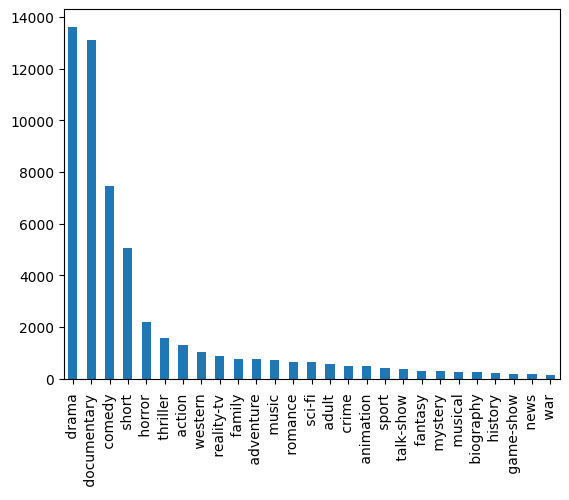

In [ ]:
train_data["Genre"].value_counts().plot(kind="bar")

## Preprocessing

In [ ]:
# encode labels
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()

train_labels=encoder.fit_transform(train_data["Genre"].to_numpy())
train_labels[:5]

array([ 8, 24,  1,  8,  8])

In [ ]:
#get class names
class_names=list(encoder.classes_)
class_names

[' action ',
 ' adult ',
 ' adventure ',
 ' animation ',
 ' biography ',
 ' comedy ',
 ' crime ',
 ' documentary ',
 ' drama ',
 ' family ',
 ' fantasy ',
 ' game-show ',
 ' history ',
 ' horror ',
 ' music ',
 ' musical ',
 ' mystery ',
 ' news ',
 ' reality-tv ',
 ' romance ',
 ' sci-fi ',
 ' short ',
 ' sport ',
 ' talk-show ',
 ' thriller ',
 ' war ',
 ' western ']

In [ ]:
#extract descriptions
train_desc=train_data["Description"].to_list()
train_desc[:2]

[' Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.',
 ' A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.']

In [ ]:
# get test labels and descriptions
test_desc=test_data["Description"].to_list()

test_labels=encoder.transform(test_data_solution["Genre"].to_numpy())

print(f"sample description: {test_desc[4]}, label: {class_names[test_labels[4]]}")

sample description:  Before he was known internationally as a martial arts superstar, Bruce Lee had appeared in a handful of Hong Kong films as a child star in the 1940s/50s. One of these early films was The More the Merrier (1955), a.k.a. We Owe it to Our Children from the Union Film Enterprise, a family melodrama written and directed by renowned filmmaker Chin Chien (My Intimate Partners). Featuring the 14-year-old Bruce Lee and future Cantonese Opera star Yuen Siu Fai, the B&W film revolves around accountant Ming (played by Cheung Wood Yau) and his wife (Tsi Lo Lin) who suffers a miscarriage in an car accident. The couple decides to adopt a baby girl, not knowing that she's the daughter given up by Ming's poor co-worker who struggles to feed a bunch of kids. Bruce Lee plays the slacker son of the landlord (Ko Lo Chuen)., label:  drama 


## Model 1: Tf-idf vectorizer with Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
TF_IDF_NB_Model=Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

In [ ]:
TF_IDF_NB_Model.fit(train_desc, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_score=TF_IDF_NB_Model.score(test_desc, test_labels)
model_score

0.4426752767527675

## Model 2: Feature Extraction with pretrained token embeddings

Universal Sentence Encoder (USE) pretrained embeddings

In [ ]:
#create one hot encoded labels
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_data["Genre"].to_numpy().reshape(-1, 1))
test_labels_one_hot=one_hot_encoder.transform(test_data_solution["Genre"].to_numpy().reshape(-1, 1))

In [ ]:
# create prefetch datasets of the train and test data
train_dataset=tf.data.Dataset.from_tensor_slices((train_desc, train_labels_one_hot))

test_dataset=tf.data.Dataset.from_tensor_slices((test_desc, test_labels_one_hot))

train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 27), dtype=tf.float64, name=None))>

In [ ]:
import tensorflow_hub as hub
# Download pretrained TensorFlow Hub USE
sentence_encoder=hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                input_shape=[],
                                dtype=tf.string,
                                trainable=False,
                                name="USE")

In [ ]:
import random
# Test out the pretrained embedding on a random sentence
random_sentence=random.choice(train_desc)
print(random_sentence)
sample_USE_embed=sentence_encoder([random_sentence])
sample_USE_embed

 Two struggling girls from different walks of life encounter a duffle bag with five million dollars cash that belongs to some gangsters. In their effort to escape the end up, inadvertently taking the identities of two heirs of a hotel emporium.


<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-3.86260487e-02, -2.77457442e-02,  2.40964051e-02,
        -1.75746977e-02,  6.00953437e-02,  4.22477834e-02,
        -4.78650853e-02, -1.60629787e-02, -6.57756701e-02,
        -8.28809887e-02,  3.82726341e-02, -4.62081805e-02,
        -1.27737485e-02,  1.22576077e-02,  2.73383483e-02,
        -7.89963901e-02, -5.60082272e-02, -2.11192369e-02,
         1.96170025e-02,  4.48858328e-02, -4.18786444e-02,
        -4.09948453e-02,  7.34349713e-02, -5.38076460e-02,
        -6.36390829e-03,  3.23119536e-02,  5.36293583e-03,
         3.75671200e-02,  1.57624613e-02, -6.43857196e-02,
         7.27765262e-02, -1.26491254e-02, -5.93167264e-04,
        -7.47878402e-02, -4.27716486e-02,  1.85789932e-02,
        -3.88470367e-02,  4.50460166e-02, -7.39879236e-02,
         5.32047674e-02,  6.80092815e-03, -4.17806320e-02,
        -4.62215692e-02, -6.19656593e-02, -3.10108867e-02,
        -8.16912130e-02,  2.61129495e-02, -4.12250161e-02,
      

In [ ]:
# Define feature extraction model using TF Hub layer
inputs=tf.keras.layers.Input(shape=[], dtype=tf.string)
x=sentence_encoder(inputs) # tokenize text and create sequence embeddings using USE
x=tf.keras.layers.Dense(256, activation="relu")(x)
outputs=tf.keras.layers.Dense(len(class_names), activation="softmax")(x)
Model_2=tf.keras.Model(inputs, outputs)

# Compile the model
Model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [ ]:
Model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 27)                6939      
                                                                 
Total params: 256936091 (980.13 MB)
Trainable params: 138267 (540.11 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
History_model_2=Model_2.fit(train_dataset, steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=10, validation_data= test_dataset, validation_steps=int(0.1*len(test_dataset)))

Epoch 1/10
169/169 [==============================] - 12s 55ms/step - loss: 2.1030 - accuracy: 0.4462 - val_loss: 1.7312 - val_accuracy: 0.5039
Epoch 2/10
169/169 [==============================] - 9s 52ms/step - loss: 1.6726 - accuracy: 0.5141 - val_loss: 1.5310 - val_accuracy: 0.5453
Epoch 3/10
169/169 [==============================] - 8s 49ms/step - loss: 1.5032 - accuracy: 0.5442 - val_loss: 1.4295 - val_accuracy: 0.5688
Epoch 4/10
169/169 [==============================] - 9s 53ms/step - loss: 1.4499 - accuracy: 0.5614 - val_loss: 1.3697 - val_accuracy: 0.5786
Epoch 5/10
169/169 [==============================] - 7s 40ms/step - loss: 1.4029 - accuracy: 0.5729 - val_loss: 1.3652 - val_accuracy: 0.5747
Epoch 6/10
169/169 [==============================] - 9s 51ms/step - loss: 1.3843 - accuracy: 0.5662 - val_loss: 1.3309 - val_accuracy: 0.5865
Epoch 7/10
169/169 [==============================] - 7s 41ms/step - loss: 1.3706 - accuracy: 0.5758 - val_loss: 1.3103 - val_accuracy: 0.590

In [ ]:
Model_2.evaluate(test_dataset)

1694/1694 [==============================] - 46s 27ms/step - loss: 1.3218 - accuracy: 0.5889


[1.3217682838439941, 0.5888745188713074]

## Model 3: SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

text_vectorizer=TfidfVectorizer()
train_desc_vec = text_vectorizer.fit_transform(train_data['Description'])
test_desc_vec = text_vectorizer.transform(test_data['Description'])

X_train, X_valid, y_train, y_valid=train_test_split(train_desc_vec,
                                                              train_labels,
                                                              test_size=0.2,
                                                              random_state=42)


In [ ]:
SVC_Model=LinearSVC()
SVC_Model.fit(X_train, y_train)

LinearSVC()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
# predict on validation subset
validation_predictions=SVC_Model.predict(X_valid)

val_accuracy=accuracy_score(y_valid, validation_predictions)
val_accuracy

0.5949460481416582

In [ ]:
# generate classification report on validation data
val_class_report=classification_report(y_valid, validation_predictions)
print(val_class_report)

              precision    recall  f1-score   support

           0       0.47      0.34      0.40       263
           1       0.82      0.44      0.57       112
           2       0.45      0.23      0.30       139
           3       0.49      0.17      0.26       104
           4       0.00      0.00      0.00        61
           5       0.54      0.59      0.56      1443
           6       0.31      0.04      0.07       107
           7       0.69      0.83      0.76      2659
           8       0.57      0.74      0.64      2697
           9       0.41      0.16      0.23       150
          10       0.11      0.01      0.02        74
          11       0.81      0.65      0.72        40
          12       1.00      0.02      0.04        45
          13       0.66      0.67      0.67       431
          14       0.60      0.58      0.59       144
          15       0.57      0.08      0.14        50
          16       0.43      0.05      0.10        56
          17       0.29    

In [ ]:
# Test dataset accuracy and classification report
test_predictions=SVC_Model.predict(test_desc_vec)
print(f"Test accuracy: {accuracy_score(test_labels, test_predictions)}")
print(classification_report(test_labels, test_predictions))

Test accuracy: 0.5897785977859779
              precision    recall  f1-score   support

           0       0.44      0.33      0.38      1314
           1       0.66      0.39      0.49       590
           2       0.51      0.23      0.32       775
           3       0.43      0.13      0.20       498
           4       0.00      0.00      0.00       264
           5       0.55      0.60      0.57      7446
           6       0.32      0.05      0.09       505
           7       0.69      0.84      0.76     13096
           8       0.57      0.73      0.64     13612
           9       0.40      0.15      0.22       783
          10       0.31      0.06      0.10       322
          11       0.83      0.64      0.72       193
          12       0.26      0.02      0.04       243
          13       0.61      0.63      0.62      2204
          14       0.61      0.53      0.57       731
          15       0.37      0.07      0.12       276
          16       0.18      0.02      0.04    

## Comparing Results

In [ ]:
def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
model_1_predictions=TF_IDF_NB_Model.predict(test_desc)
model_2_predictions=tf.argmax(Model_2.predict(test_dataset), axis=1)
model_3_predictions=SVC_Model.predict(test_desc_vec)

model_1_results=calculate_results(test_labels, model_1_predictions)
model_2_results=calculate_results(test_labels, model_2_predictions)
model_3_results=calculate_results(test_labels, model_3_predictions)

print(f"Model 1 (Tfidf Naive Bayes) results: {model_1_results}")
print(f"Model 2 (pretrained USE embeddings) results: {model_2_results}")
print(f"Model 3 (SVC) results: {model_3_results}")

1694/1694 [==============================] - 38s 23ms/step
Model 1 (Tfidf Naive Bayes) results: {'accuracy': 44.26752767527675, 'precision': 0.40636510764903433, 'recall': 0.4426752767527675, 'f1': 0.30277842214834066}
Model 2 (pretrained USE embeddings) results: {'accuracy': 58.88745387453874, 'precision': 0.5554847145540214, 'recall': 0.5888745387453874, 'f1': 0.5562492095894154}
Model 3 (SVC) results: {'accuracy': 58.97785977859778, 'precision': 0.5613783785726706, 'recall': 0.5897785977859779, 'f1': 0.5607550463323367}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Combine model results into a dataframe
combined_results = pd.DataFrame({"Model 1 (Tfidf Naive Bayes)": model_1_results,
                                  "Model 2 (pretrained USE embeddings)": model_2_results,
                                  "Model 3 (SVC)": model_3_results})
combined_results = combined_results.transpose()
combined_results

,accuracy,precision,recall,f1
Model 1 (Tfidf Naive Bayes),44.267528,0.406365,0.442675,0.302778
Model 2 (pretrained USE embeddings),58.887454,0.555485,0.588875,0.556249
Model 3 (SVC),58.977860,0.561378,0.589779,0.560755


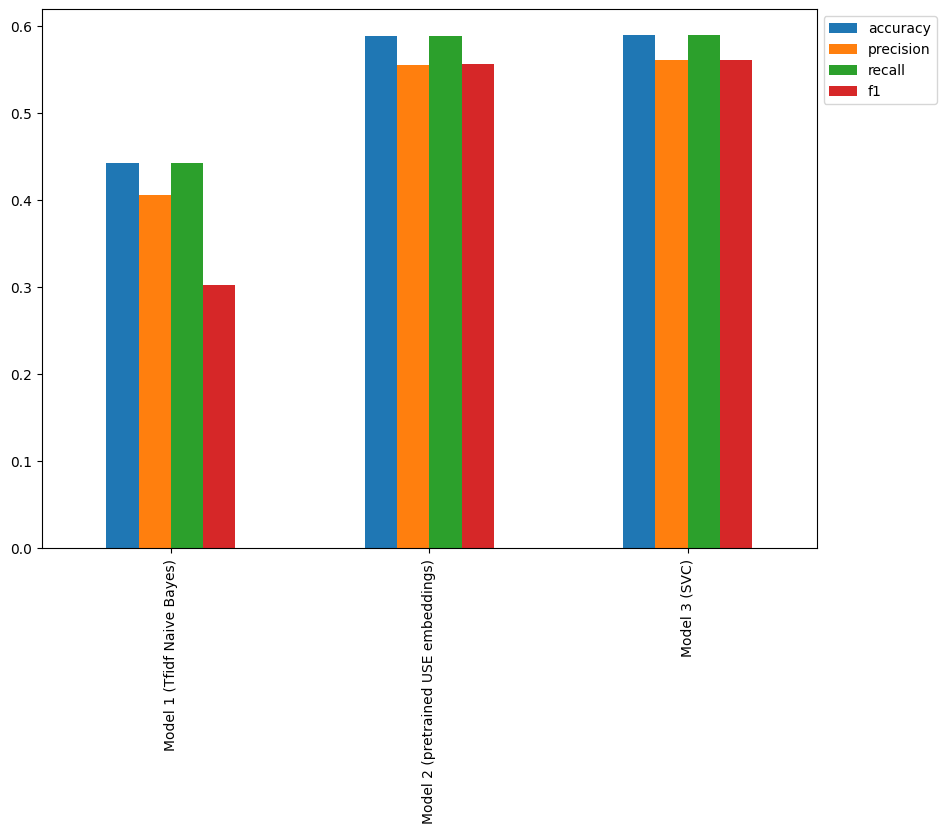

In [ ]:
# Plot results comparison
combined_results["accuracy"] = combined_results["accuracy"]/100
combined_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));